In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [24]:
## Read folder content

def read_images_data(data_dir) :
    """
    Read data from diroctory
    data_dir : data diroctory
    """
    try :
        classes = os.listdir(data_dir)
        return classes
    except Exception as e :
        print(f"An error occurred: {e}")

In [25]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification")

Skipping, found downloaded files in "./garbage-classification" (use force=True to force download)


In [26]:
DATA_DIR = '/content/garbage-classification/garbage classification/Garbage classification'
classes = read_images_data(DATA_DIR)
print(f' - classes exist in data : {classes}')

 - classes exist in data : ['plastic', 'cardboard', 'glass', 'paper', 'metal', 'trash']


In [29]:
# Model hyperparameters
latent_dim = 100      # size of noise vector
image_size = 64       # generated image size (64x64)
channels = 3          # RGB images
batch_size = 128
epochs = 50
lr = 0.0002
beta1 = 0.5

# Dataset path (adjust to your folder structure)
data_dir = "/content/garbage-classification/Garbage classification/Garbage classification/trash"


In [28]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # scale to [-1, 1]
])

dataset = datasets.ImageFolder(root="/content/garbage-classification/garbage classification/Garbage classification", transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)


In [30]:
ample_batch, _ = next(iter(dataloader))
img_shape = tuple(sample_batch[0].shape)  # (3, 64, 64)
print("Detected image shape:", img_shape)

Detected image shape: (3, 64, 64)


In [31]:
class Generator(nn.Module):
    def __init__(self, img_shape, z_dim=100):
        super(Generator, self).__init__()
        self.img_shape = img_shape
        self.z_dim = z_dim
        self.model = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, int(torch.prod(torch.tensor(img_shape)))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(z.size(0), *self.img_shape)
        return img

In [32]:
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(int(torch.prod(torch.tensor(img_shape))), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity


In [33]:
generator = Generator(img_shape).to(device)
discriminator = Discriminator(img_shape).to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [34]:
epochs = 50
z_dim = 100
os.makedirs("gan_images", exist_ok=True)

for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = imgs.to(device)
        batch_size = real_imgs.size(0)

        # Labels
        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)

        # -------------------
        # Train Generator
        # -------------------
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, z_dim, device=device)
        gen_imgs = generator(z)
        g_loss = criterion(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # -------------------
        # Train Discriminator
        # -------------------
        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(real_imgs), valid)
        fake_loss = criterion(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        if i % 100 == 0:
            print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] "
                  f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

    # Save sample every epoch
    save_image(gen_imgs[:25], f"gan_images/{epoch}.png", nrow=5, normalize=True)

[Epoch 0/50] [Batch 0/20] [D loss: 0.6978] [G loss: 0.7076]
[Epoch 1/50] [Batch 0/20] [D loss: 0.2892] [G loss: 1.0806]
[Epoch 2/50] [Batch 0/20] [D loss: 0.0581] [G loss: 2.9867]
[Epoch 3/50] [Batch 0/20] [D loss: 0.0472] [G loss: 3.4148]
[Epoch 4/50] [Batch 0/20] [D loss: 0.8498] [G loss: 0.2594]
[Epoch 5/50] [Batch 0/20] [D loss: 0.2084] [G loss: 1.3482]
[Epoch 6/50] [Batch 0/20] [D loss: 0.1762] [G loss: 1.8885]
[Epoch 7/50] [Batch 0/20] [D loss: 0.1864] [G loss: 1.9155]
[Epoch 8/50] [Batch 0/20] [D loss: 0.2582] [G loss: 1.3210]
[Epoch 9/50] [Batch 0/20] [D loss: 0.2604] [G loss: 1.5288]
[Epoch 10/50] [Batch 0/20] [D loss: 0.2698] [G loss: 1.1905]
[Epoch 11/50] [Batch 0/20] [D loss: 0.2214] [G loss: 1.8645]
[Epoch 12/50] [Batch 0/20] [D loss: 0.1316] [G loss: 2.6836]
[Epoch 13/50] [Batch 0/20] [D loss: 0.1566] [G loss: 2.0368]
[Epoch 14/50] [Batch 0/20] [D loss: 0.1259] [G loss: 2.5111]
[Epoch 15/50] [Batch 0/20] [D loss: 0.1162] [G loss: 1.9942]
[Epoch 16/50] [Batch 0/20] [D loss

In [35]:
# ------------------------------
# Track Losses
# ------------------------------
G_losses = []
D_losses = []

for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = imgs.to(device)
        batch_size = real_imgs.size(0)

        # Labels
        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, z_dim, device=device)
        gen_imgs = generator(z)
        g_loss = criterion(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(real_imgs), valid)
        fake_loss = criterion(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Save losses for visualization
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        if i % 100 == 0:
            print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] "
                  f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

    # Save sample every epoch
    save_image(gen_imgs[:25], f"gan_images/{epoch}.png", nrow=5, normalize=True)


[Epoch 0/50] [Batch 0/20] [D loss: 0.4988] [G loss: 3.5528]
[Epoch 1/50] [Batch 0/20] [D loss: 0.6624] [G loss: 0.5009]
[Epoch 2/50] [Batch 0/20] [D loss: 0.2617] [G loss: 1.7465]
[Epoch 3/50] [Batch 0/20] [D loss: 0.3115] [G loss: 1.1794]
[Epoch 4/50] [Batch 0/20] [D loss: 0.3651] [G loss: 0.9105]
[Epoch 5/50] [Batch 0/20] [D loss: 0.6154] [G loss: 0.5026]
[Epoch 6/50] [Batch 0/20] [D loss: 0.3619] [G loss: 2.7063]
[Epoch 7/50] [Batch 0/20] [D loss: 0.2846] [G loss: 1.3215]
[Epoch 8/50] [Batch 0/20] [D loss: 0.3393] [G loss: 0.9939]
[Epoch 9/50] [Batch 0/20] [D loss: 0.3224] [G loss: 1.4277]
[Epoch 10/50] [Batch 0/20] [D loss: 0.2918] [G loss: 1.7377]
[Epoch 11/50] [Batch 0/20] [D loss: 0.4698] [G loss: 0.6467]
[Epoch 12/50] [Batch 0/20] [D loss: 0.5928] [G loss: 3.2498]
[Epoch 13/50] [Batch 0/20] [D loss: 0.2776] [G loss: 1.3117]
[Epoch 14/50] [Batch 0/20] [D loss: 0.5086] [G loss: 3.0860]
[Epoch 15/50] [Batch 0/20] [D loss: 0.5334] [G loss: 0.7235]
[Epoch 16/50] [Batch 0/20] [D loss

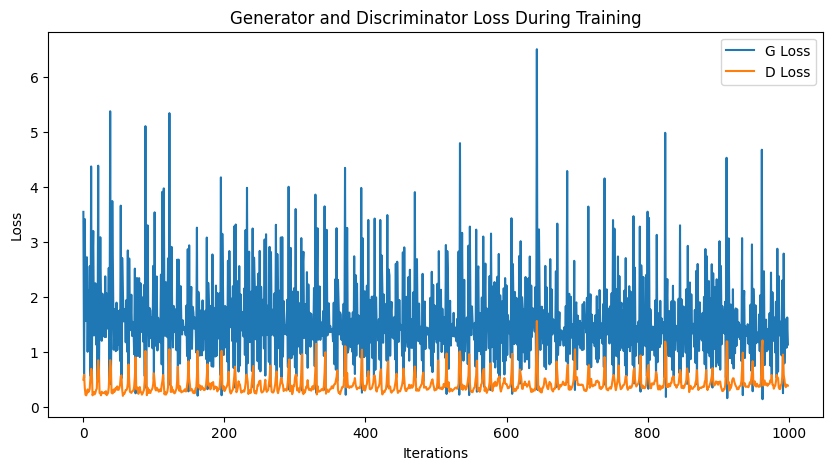

In [36]:
# ------------------------------
#Plot Loss Curves
# ------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G Loss")
plt.plot(D_losses, label="D Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


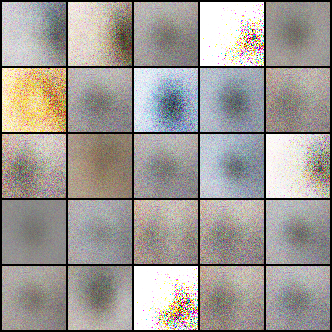

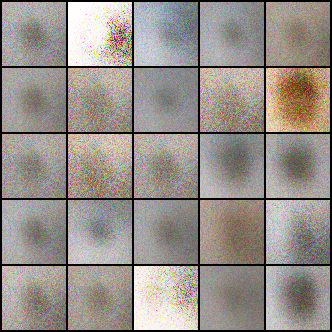

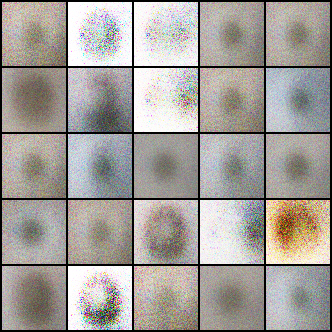

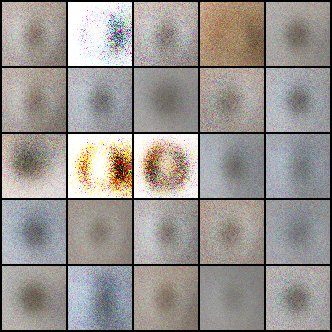

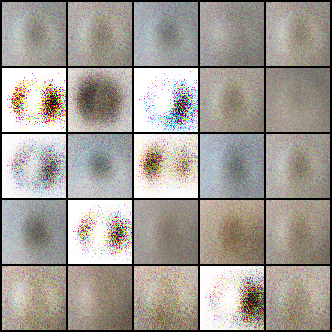

In [37]:
# ------------------------------
# Show Generated Images Progress
# ------------------------------
import glob
from IPython.display import Image, display

# Display last 5 epochs
image_list = sorted(glob.glob("gan_images/*.png"))[-5:]
for img_path in image_list:
    display(Image(filename=img_path))


**Report: GANs for Data Augmentation**

**1. Introduction**

Generative Adversarial Networks (GANs) are widely used for data augmentation because they can synthesize realistic data samples that expand limited datasets. However, training GANs is inherently unstable, and when the dataset is highly variable or inconsistent, the generated images often lack clarity and structure.

Your experiment trains a GAN on image data with shape (3, 64, 64), with the goal of producing synthetic samples for augmentation.

**Training Setup**

Generator: Takes random noise vectors as input and outputs images of size (3, 64, 64).

Discriminator: Classifies real vs. fake images.

Loss Functions: Binary Cross-Entropy (BCE).

Optimizer: Likely Adam (not explicitly stated, but standard).

Epochs: 50.

Batch Size: 128.

**Observed Results**
**Generated Samples**

The generated images (see attached grid) show blurry and noisy textures.

Few images exhibit localized patterns, but there’s no clear structure or object-level detail.

Color distributions appear inconsistent (patchy yellows, browns, and grays).

**Training Logs**

Discriminator Loss: fluctuates between 0.25 – 0.70. This suggests it learns to differentiate, but not consistently.

Generator Loss: oscillates widely (0.4 – 3.5), which reflects difficulty in fooling the discriminator.

**Examples:**

Early epochs: G loss = 3.5, unstable → generator producing noise.

Mid epochs: Loss stabilizes (1.2 – 2.5), showing some learning.

Late epochs: Still inconsistent; spikes in generator loss indicate mode collapse or instability.

**Challenges in GAN Data Augmentation**

**Data Variability**

If the training dataset contains diverse samples (different colors, textures, shapes), the GAN struggles to capture all distributions.

This explains why outputs look like fuzzy averages of multiple categories.

**Mode Collapse**

Generator may learn to produce a few repetitive patterns instead of capturing full diversity.

Seen in epochs where outputs look similar but blurry.

**Training Instability**

GAN optimization is a minimax game: if discriminator learns too fast, generator collapses, and vice versa.

Loss oscillations in your logs reflect this.

**Quality vs. Diversity Trade-off**

Strong discriminator → high-quality but less diverse images.

Weak discriminator → diverse but noisy images.

**Why GAN-based Augmentation is Hard**

Unlike traditional augmentation (rotation, flips, scaling), GANs must model the full data distribution. When the dataset is:

**Small** → generator memorizes, producing unrealistic samples.

**Highly variable** → generator fails to converge, leading to blurry/noisy outputs.

This makes GAN augmentation particularly hard in domains with complex, varied data (e.g., natural images, medical scans, satellite imagery).